In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
import pandas as pd, numpy as np
from db_queries import get_outputs as go, get_ids, get_population
from vivarium import Artifact

In [3]:
!whoami
!date

nicoly
Tue Jul 20 14:57:40 PDT 2021


# Caluculate wasting category-specific mortality hazards

In [4]:
#Goal:

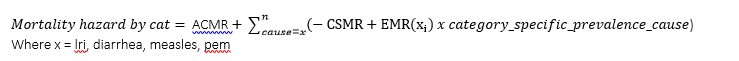

In [5]:
# need cat-specific cause prevalences

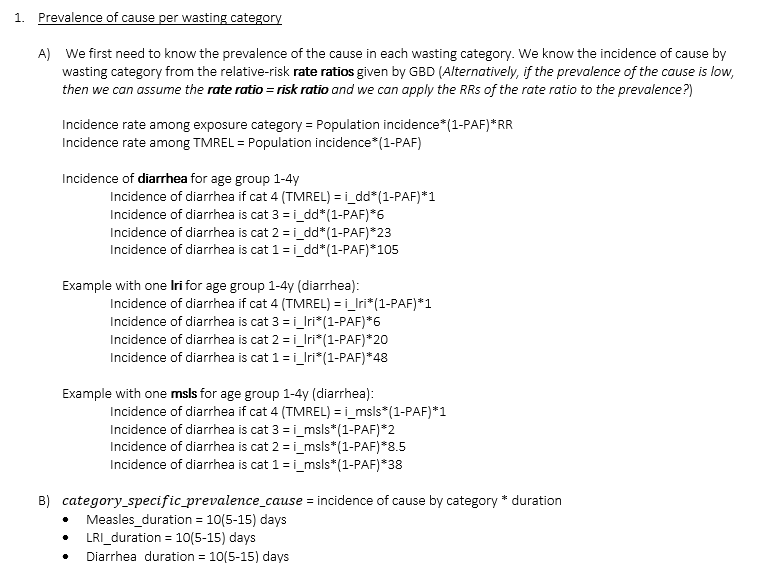

In [6]:
# using gbd 2020 RRs, as GBD 2019 RRs were unrealistically high (>100 for SAM/diarrhea)

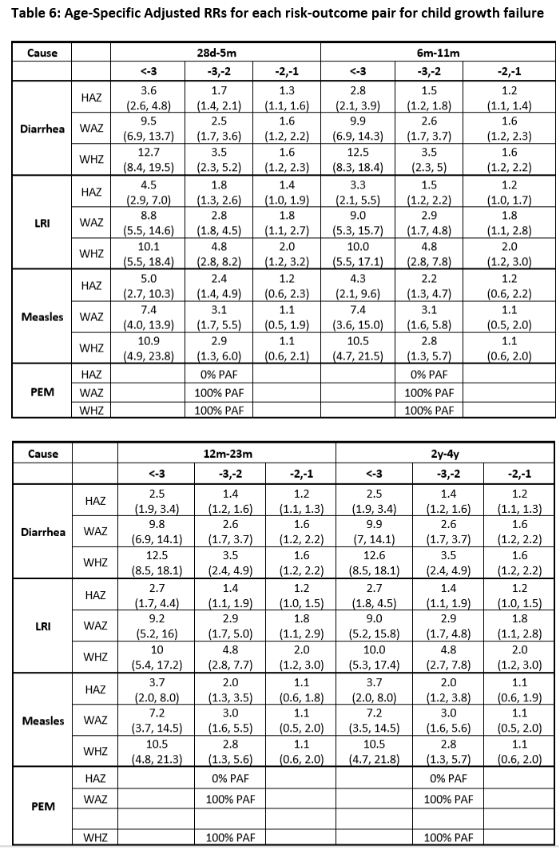

In [4]:
causes = ['diarrhea','lri','measles','pem']

In [5]:
# populate a dict of all RRs of {cause} given wasting cat
## risk among exposed / risk among unexposed

rrs = {j:{i:{} for i in ['28d-5m','6m-11m','12m-23m','2y-4y']} for j in causes}

In [6]:
rrs['measles']['28d-5m'] = {
    'cat4':1, #tmrel
    'cat3':1.1,
    'cat2':2.9,
    'cat1':10.9,
}

rrs['measles']['6m-11m'] = {
    'cat4':1.0, #tmrel
    'cat3':1.1,
    'cat2':2.8,
    'cat1':10.5,
}

rrs['measles']['12m-23m'] = {
    'cat4':1, #tmrel
    'cat3':1.1,
    'cat2':2.8,
    'cat1':10.5,
}

rrs['measles']['2y-4y'] = {
    'cat4':1.0, #tmrel
    'cat3':1.1,
    'cat2':2.8,
    'cat1':10.5,
}

rrs['lri']['28d-5m'] = {
    'cat4':1, #tmrel
    'cat3':2.0,
    'cat2':4.8,
    'cat1':10.1,
}

rrs['lri']['6m-11m'] = {
    'cat4':1.0, #tmrel
    'cat3':2.0,
    'cat2':4.8,
    'cat1':10.0,
}

rrs['lri']['12m-23m'] = {
    'cat4':1, #tmrel
    'cat3':2.0,
    'cat2':4.8,
    'cat1':10.0,
}

rrs['lri']['2y-4y'] = {
    'cat4':1.0, #tmrel
    'cat3':2.0,
    'cat2':4.8,
    'cat1':10.0,
}

rrs['diarrhea']['28d-5m'] = {
    'cat4':1, #tmrel
    'cat3':1.6,
    'cat2':3.5,
    'cat1':12.7,
}

rrs['diarrhea']['6m-11m'] = {
    'cat4':1, #tmrel
    'cat3':1.6,
    'cat2':3.5,
    'cat1':12.5,
}

rrs['diarrhea']['12m-23m'] = {
    'cat4':1, #tmrel
    'cat3':1.6,
    'cat2':3.5,
    'cat1':12.5,
}

rrs['diarrhea']['2y-4y'] = {
    'cat4':1, #tmrel
    'cat3':1.6,
    'cat2':3.5,
    'cat1':12.6,
}

In [10]:
#pop-weight these...

# from db_queries import get_population

# get_population(age_group_id=[4,5], location_id=179, year_id=2019, sex_id=3, release_id=9, tool_type_id=3)

In [11]:
# ----we don't need to use RRs for PEM-----------------

for age_group in ['28d-5m', '6m-11m', '12m-23m', '2y-4y']:
    rrs['pem'][age_group] = {
        'cat4':np.infty, #tmrel = risk amonge exposed / risk among unexposed = 0 / 0
        'cat3':np.infty,
        'cat2':np.infty,
        'cat1':np.infty,
    }

In [12]:
cats = [f'cat{i}' for i in range(1,5)]
rr_df = pd.DataFrame(
    [[cause, age] + [rrs[cause][age][i] for i in cats]
     for cause in rrs.keys() 
     for age in rrs['diarrhea'].keys()],
    columns = ['cause','age_group'] + cats
)

In [13]:
rr_df

,cause,age_group,cat1,cat2,cat3,cat4
0,diarrhea,28d-5m,12.7,3.5,1.6,1.0
1,diarrhea,6m-11m,12.5,3.5,1.6,1.0
2,diarrhea,12m-23m,12.5,3.5,1.6,1.0
3,diarrhea,2y-4y,12.6,3.5,1.6,1.0
4,lri,28d-5m,10.1,4.8,2.0,1.0
5,lri,6m-11m,10.0,4.8,2.0,1.0
6,lri,12m-23m,10.0,4.8,2.0,1.0
7,lri,2y-4y,10.0,4.8,2.0,1.0
8,measles,28d-5m,10.9,2.9,1.1,1.0
9,measles,6m-11m,10.5,2.8,1.1,1.0


#### Pop-weight RRs

In [14]:
age_id_map = {
    '28d-5m': 388,
    '6m-11m': 389,
    '12m-23m': 238,
    '2y-4y': 34
}

In [15]:
# checked that iterative, step1, step2, step3, release2, all have same vals. (usa_re different)
pop_weights = get_population(age_group_id=list(age_id_map.values()), location_id=179, year_id=2019, sex_id=3,
               gbd_round_id = 7, decomp_step = 'release2')

pop_weights['group_id'] = pop_weights.age_group_id.map({34: 5, 238: 5, 388: 4, 389: 4})
pop_weights['age_weight'] = pop_weights.groupby('group_id').transform('sum').population
pop_weights['age_weight'] = pop_weights.population / pop_weights.age_weight

weights = {i:j for (i,j) in zip(pop_weights.age_group_id, pop_weights.age_weight)}

In [16]:
# create df of weighted rrs
rr_df['age_group_id_finer'] = rr_df.age_group.map(age_id_map)
rr_df['weight'] = rr_df.age_group_id_finer.map(weights)
rr_df['age_group_id'] = rr_df.age_group_id_finer.map({34: 5, 238: 5, 388: 4, 389: 4})

rr_df = rr_df.set_index(['cause','age_group_id'])
rr_df = rr_df[cats].mul(rr_df.weight, axis = 0).reset_index().groupby(['cause','age_group_id']).sum().reset_index()

In [17]:
# add weighted rrs to dictionary
for cause in causes:
    for age_group_id in [4,5]:
        rrs[cause][age_group_id] = {cat:float(rr_df.loc[(rr_df.cause==cause) &
                                                        (rr_df.age_group_id==age_group_id),cat
                                                       ]) for cat in cats}

In [18]:
# post neonatal = age_group_id 4 = 28 days - 1 year
# 1 to 4 = age_group_id 5 = [1 to 5 years)

## PULL DATA

### Pulling PAFs 

#### we don't use the GBD 2019 PAFs, because we're using GBD 2020 RRs. We will instead calculate our own PAFs.

In [19]:
# GBD 2019 PAFs
# wasting_pafs = go(
#     topic="rei",
#     cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
#     gbd_round_id=6, #gbd 2019
#     age_group_id=[4,5], 
#     sex_id=[1,2,3],
#     year_id=2019,
#     rei_id=[240], 
#     decomp_step="step5",
#     measure_id='all',
#     metric_id=2,
#     location_id=179
# )

# # we only have PAFs for DALYs, deaths, and YLLs. no YLDs
# wasting_pafs.loc[
#     (wasting_pafs.sex_id==3) &
#     (wasting_pafs.age_group_id==5) &
#     (wasting_pafs.val.notna()) &
#     (wasting_pafs.val.notna()),
#     ['age_group_name','measure_name','rei_name','cause_name','val','upper','lower']
# ].sort_values(['age_group_name','cause_name','measure_name']).set_index(
# ['rei_name','age_group_name','cause_name','measure_name'])

### NOTE: for PAF of {cause} attributable to {risk=wasting}, because the risk category does not affect the cause duration (or EMR?), we can assume the incidence PAF == prevalence PAF. Thus we will use the GBD Deaths PAF, above. however, we include below how we would hand-calculate the PAF using the exposure category prevalences and RRs

### The PAF we want: 
#### the proportional reduction of cause (prevalence) that would occur if wasting cat1, 2, or 3 were to be reduced to cat 4 (tmrel).

We use this equation for PAF
$$ \frac{Pcat\times(RRc-1)}{Pcat\times(RRc-1)+1} = PAF \ $$

OR 

$$ \frac{\sum(Pcat)\times(RRcat)-1}{\sum(Pcat)\times(RRcat)} = PAF \ $$

In [21]:
# ((paf_calc.prev * paf_calc.rr).sum() - 1) / (paf_calc.prev * paf_calc.rr).sum()

### Pulling incidence

In [22]:
# pull incidence
cause_inc = go(
    topic="cause",
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    gbd_round_id=6,
    age_group_id=[4,5],
    sex_id=[1,2,3],
    year_id=2019,
    decomp_step="step5",
    measure_id=6, #incidence
    metric_id=3, #rate
    location_id=179
)

In [23]:
cause_inc.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower
0,4,322,179,6,3,1,2019,lri,Post Neonatal,Lower respiratory infections,False,Ethiopia,admin0,Incidence,Rate,Male,0.090151,0.116393,0.068537
1,4,322,179,6,3,2,2019,lri,Post Neonatal,Lower respiratory infections,False,Ethiopia,admin0,Incidence,Rate,Female,0.093498,0.119482,0.071913
2,4,322,179,6,3,3,2019,lri,Post Neonatal,Lower respiratory infections,False,Ethiopia,admin0,Incidence,Rate,Both,0.091784,0.118401,0.070490
3,4,302,179,6,3,1,2019,diarrhea,Post Neonatal,Diarrheal diseases,False,Ethiopia,admin0,Incidence,Rate,Male,2.767624,3.326221,2.251194
4,4,302,179,6,3,2,2019,diarrhea,Post Neonatal,Diarrheal diseases,False,Ethiopia,admin0,Incidence,Rate,Female,2.779747,3.354783,2.267587


### Pulling CSMR 

In [24]:
#pull csmr
csmr_df = go(
    "cause", 
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=1, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

csmr_df = csmr_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

### Pulling prevalence

In [25]:
# pull prev (for emr)
prev_df = go(
    "cause", 
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=5, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

prev_df = prev_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

In [26]:
prev_df.head()

val  \
metric_name cause_id cause_name         sex_id age_group_id             
Rate        302      Diarrheal diseases 1      4             0.045568   
                                               5             0.026452   
                                        2      4             0.045650   
                                               5             0.026259   
                                        3      4             0.045608   

                                                                upper  \
metric_name cause_id cause_name         sex_id age_group_id             
Rate        302      Diarrheal diseases 1      4             0.053138   
                                               5             0.033044   
                                        2      4             0.053132   
                                               5             0.033100   
                                        3      4             0.052980   

                                                                lower  
metric_name cause_id cause_name         sex_id age_group_id            
Rate        302      Diarrheal diseases 1      4             0.038577  
                                               5             0.020762  
                                        2      4             0.038413  
                                               5             0.020612  
                                        3      4             0.038552

### Calculating EMR 

In [27]:
# calculate emr
emr_df = csmr_df / prev_df

### Pulling ACMR

In [28]:
# pull acmr
acmr_df = go(
    "cause", 
    cause_id=294, #all causes
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=1, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

acmr_df = acmr_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

### Pulling wasting cat exposure - from ARTIFACT

#### Calculating the correct PAF, because we don't want to use 2019 RRs

In [29]:
#pulling from artifact - how to pull centrally from GBD? 
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2019', 'age_start <  0.076712', f'age_end <= 5'])


art_wasting_exp = art.load('risk_factor.child_wasting.exposure').reset_index()
art_wasting_exp['prev'] = art_wasting_exp.iloc[:, 5:].mean(axis=1)
wasting_exp = art_wasting_exp[['sex', 'age_start', 'age_end', 'year_start', 'year_end', 'parameter', 'prev']]
wasting_exp['sex_id'] = np.where(wasting_exp['sex'] == 'Male', 1, 2)
wasting_exp['age_group_id'] = np.where(wasting_exp['age_start'] == 0, 4, 5) 

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [30]:
wasting_exp.head()

,sex,age_start,age_end,year_start,year_end,parameter,prev,sex_id,age_group_id
0,Female,0.000000,0.019178,2019,2020,cat1,0.024557,2,4
1,Female,0.000000,0.019178,2019,2020,cat2,0.082311,2,4
2,Female,0.000000,0.019178,2019,2020,cat3,0.201385,2,4
3,Female,0.000000,0.019178,2019,2020,cat4,0.691747,2,4
4,Female,0.019178,0.076712,2019,2020,cat1,0.024610,2,5


In [31]:
emr_df = emr_df.reset_index()
csmr_df = csmr_df.reset_index()
prev_df = prev_df.reset_index()
acmr_df = acmr_df.reset_index()

## DEFINE FNS

In [32]:
wasting_exp.loc[
        (wasting_exp.sex_id == 2) & (wasting_exp.age_group_id == 4)
    ]

,sex,age_start,age_end,year_start,year_end,parameter,prev,sex_id,age_group_id
0,Female,0.0,0.019178,2019,2020,cat1,0.024557,2,4
1,Female,0.0,0.019178,2019,2020,cat2,0.082311,2,4
2,Female,0.0,0.019178,2019,2020,cat3,0.201385,2,4
3,Female,0.0,0.019178,2019,2020,cat4,0.691747,2,4


In [33]:
def calc_paf(cause, sex_id, age_group_id):
    paf_calc = wasting_exp.loc[
        (wasting_exp.sex_id == sex_id) & (wasting_exp.age_group_id == age_group_id)
    ]
    #TODO: STOP USING '6m-11m' AFTER POP WEIGHTING THE AGE GROUPS
    paf_calc['rr'] = paf_calc.parameter.map(rrs[cause][age_group_id]) 

#     paf = (p_cat1*rr_1 + p_cat2*rr_2 + p_cat3*rr_3 + p_cat4*rr_4 - 1)/
#           (p_cat1*rr_1 + p_cat2*rr_2 + p_cat3*rr_3 + p_cat4*rr_4)
    return ((paf_calc.prev * paf_calc.rr).sum() - 1) / (paf_calc.prev * paf_calc.rr).sum()


In [34]:
checkout_pafs = pd.DataFrame([(cause, 
                               sex,
                               age,
                               calc_paf(cause, sex, age),
                              ) 
                              for cause in ['diarrhea','lri','measles'] 
                              for sex in [1,2] 
                              for age in [4,5]],
            columns = ['cause','sex_id','age_group','paf'])

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [35]:
# GBD PAFs from 2019
wasting_pafs = go(
    topic="rei",
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    gbd_round_id=6, #gbd 2019
    age_group_id=[4,5], 
    sex_id=[1,2,3],
    year_id=2019,
    rei_id=[240], 
    decomp_step="step5",
    measure_id='all',
    metric_id=2,
    location_id=179
)

wasting_pafs.loc[
    (wasting_pafs.measure_name=="Deaths") & 
    (wasting_pafs.sex_id.isin([1,2])) &
    (wasting_pafs.age_group_id.isin([4,5])) &
    (wasting_pafs.val.notna()) &
    (wasting_pafs.val.notna()),
].sort_values(['cause_name','sex_id','age_group_id']).set_index(['cause_name','sex_id','age_group_id'])[['val','lower','upper']]

val     lower     upper
cause_name                   sex_id age_group_id                              
Diarrheal diseases           1      4             0.863555  0.715037  0.918671
                                    5             0.784039  0.573184  0.866246
                             2      4             0.891015  0.764967  0.934559
                                    5             0.841212  0.681368  0.903734
Lower respiratory infections 1      4             0.798400  0.580686  0.905702
                                    5             0.723064  0.471423  0.862640
                             2      4             0.830527  0.642735  0.921467
                                    5             0.777916  0.555161  0.894641
Measles                      1      4             0.440686  0.100424  0.929423
                                    5             0.325274 -0.000052  0.881316
                             2      4             0.490625  0.151472  0.944033
                                    5             0.394207  0.050832  0.917134
Protein-energy malnutrition  1      4             1.000000  1.000000  1.000000
                                    5             1.000000  1.000000  1.000000
                             2      4             1.000000  1.000000  1.000000
                                    5             1.000000  1.000000  1.000000

In [36]:
#these are way lower than the gbd 2019 pafs (good), except for measles (was this expected?).
checkout_pafs

,cause,sex_id,age_group,paf
0,diarrhea,1,4,0.455078
1,diarrhea,1,5,0.455065
2,diarrhea,2,4,0.379382
3,diarrhea,2,5,0.379415
4,lri,1,4,0.484649
5,lri,1,5,0.484415
6,lri,2,4,0.424070
7,lri,2,5,0.423813
8,measles,1,4,0.371929
9,measles,1,5,0.367319


In [37]:
def get_cat_specific_inc(cause, cat, sex_id, age_group_id):
    
    #get cause id
    cause_map = {
        'diarrhea':302,
        'lri':322,
        'measles':341,
        'pem':387
    }
    cause_id = cause_map[cause]
    
    duration = 10 #days (TODO: check same for diarrhea, lri, measles)
    
    #------------------------------------------------------------
#     paf = float(wasting_pafs.loc[
#         (wasting_pafs.sex_id==sex_id) &
#         (wasting_pafs.cause_id==cause_id) &
#         (wasting_pafs.age_group_id==age_group_id) &
#         (wasting_pafs.measure_id==1)].val) #deaths
    
    #------------------------------------------------------------
#     Derive pafs based on the category specific prevalence of the cause and RR

    paf = calc_paf(cause, sex_id, age_group_id)
    #------------------------------------------------------------
    inc = float(cause_inc[
            (cause_inc.sex_id==sex_id) &
            (cause_inc.cause_id==cause_id) &
            (cause_inc.age_group_id==age_group_id)].val)
    
    #TODO: STOP USING '6m-11m' AFTER POP WEIGHTING THE AGE GROUPS
    return inc*(1-paf)*rrs[cause][age_group_id][cat]

In [38]:
# what metric is this? incident cases / person-year?
# ya, I think so, cases/person-year

[get_cat_specific_inc('diarrhea', cat, 2, 4) for cat in ['cat1','cat2','cat3','cat4']]

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

[21.724572842377807, 6.038069202259317, 2.7602602067471165, 1.7251626292169477]

In [39]:
def get_cat_specific_prev(cause, cat, sex_id, age_group_id):
    duration = 10 #days. TODO: check that this is true across measles, lri, diarrhea
    return duration * get_cat_specific_inc(cause, cat, sex_id, age_group_id)

In [40]:
def get_cat_specific_mortality_hazard(cat, sex_id, age_group_id):
    
    """
    calculates:
    mortality_{cat 1&2}: acmr + sum([(emr_i*prev_i - cmsr_i) for i in diar,lri,msl]) + (emr_pem*1 - cmsr_pem)
    mortality_{cat 3&4}: acmr + sum([(emr_i*prev_i - cmsr_i) for i in diar,lri,msl]) - (cmsr_pem)
    
    acmr - csmr(diarrhea) + prev_diar*emr(diarrhea) - cmsr(lri) + prev_csmr*emr(diarrhea)
    
    """
    ## initialize vars
    mortality = 0    
    cause_id_map = {302: 'diarrhea', 322: 'lri', 341: 'measles', 387: 'pem'}
    causes = cause_id_map.keys()
    
    ## pull acmr
    acmr = float(acmr_df.loc[        
        (acmr_df.age_group_id==age_group_id) &
        (acmr_df.sex_id==sex_id)].val)
    
    # add ACMR to mortality
    mortality += acmr

    # for each cause
    for cause_id in causes:
        csmr = float(csmr_df.loc[            
            (csmr_df.age_group_id==age_group_id) &
            (csmr_df.sex_id==sex_id) &
            (csmr_df.cause_id==cause_id)].val)
        emr = float(emr_df.loc[
            (emr_df.age_group_id==age_group_id) &
            (emr_df.sex_id==sex_id) &
            (emr_df.cause_id==cause_id)].val)
        
        # if PEM, we only add emr for cat1/2. in this case, we add all PEM EMR
        if cause_id==387:
            if cat in ['cat1','cat2']:
                mortality += -1*csmr + emr
            else:
                mortality += -1*csmr
                
        # if not PEM, add -csmr(cause) + prev-weighted emr(cause)
        else:
            cause = cause_id_map[cause_id]
            prev = get_cat_specific_prev(cause, cat, sex_id, age_group_id)
            mortality += -1*csmr + emr*prev
            
    return (1 - np.exp(-1*mortality * 1/365))

## RESULTS

In [41]:
#populate df of mortality hazards
df = pd.DataFrame(
    [(sex_id, age_group_id, cat,
      get_cat_specific_mortality_hazard(cat,sex_id,age_group_id),
     'year')
     for sex_id in [1,2]
     for age_group_id in [4,5]
     for cat in ['cat1','cat2','cat3','cat4']],
    columns = ['sex_id','age_group_id','cat','mortality_hazard','time_unit']
)

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [42]:
df

,sex_id,age_group_id,cat,mortality_hazard,time_unit
0,1,4,cat1,0.052008,year
1,1,4,cat2,0.016679,year
2,1,4,cat3,0.007460,year
3,1,4,cat4,0.004459,year
4,1,5,cat1,0.014163,year
5,1,5,cat2,0.004484,year
6,1,5,cat3,0.001987,year
7,1,5,cat4,0.001206,year
8,2,4,cat1,0.052866,year
9,2,4,cat2,0.017372,year


In [43]:
df.to_csv('/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions/cat_strat_mort_2021_07_13.csv', index = False)

In [44]:
# df.to_csv('/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions/cat_strat_mort_2021_06_22.csv', index = False)

In [45]:
# df.to_csv('/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions/cat_strat_mort_2021_06_08.csv', index = False)

In [2]:
from db_queries import get_ids
get_ids("age_group")

,age_group_id,age_group_name
0,1,Under 5
1,2,Early Neonatal
2,3,Late Neonatal
3,4,Post Neonatal
4,5,1 to 4
...,...,...
426,429,1 to 6 days
427,430,< 19 years
428,431,5 to 64
429,432,6 to 8 months
